# Grammar parameter fitting via VI

Try to fit the parameters of this grammar, given a library of observed points, with a VI strategy that evolves parameterized posteriors over the poses of the nodes explaining each observation.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_fixed_structure.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)

def make_orthographic(xmin,  xmax, ymin, ymax, camera_position):
    # Taken from https://github.com/RobotLocomotion/drake/blob/master/bindings/pydrake/systems/meshcat_visualizer.py
    camera = meshcat_geom.OrthographicCamera(
        left=xmin, right=xmax, top=ymax, bottom=ymin, near=-1000, far=1000)
    vis['/Cameras/default/rotated'].set_object(camera)
    vis['/Cameras/default'].set_transform(
        RigidTransform(camera_position).GetAsMatrix4())

    # Lock the orbit controls.
    vis['/Cameras/default/rotated/<object>'].set_property(
        "position", [0, 0, 0])
    vis['/Background'].set_property("visible", False)
    vis['/Grid'].set_property("visible", False)
    vis['/Axes'].set_property("visible", False)
        
make_orthographic(-2, 2, -2, 2, np.array([0., 0., 1.]))

from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7016/static/
Meshcat url:  http://127.0.0.1:7016/static/


  0%|          | 0/50 [00:00<?, ?it/s]

Saving...
Loading...


[2021-09-10 20:12:55.209] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Loaded 50 scenes.


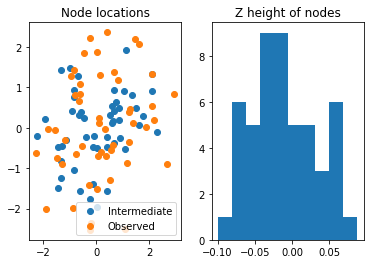

In [3]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 50
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = RootNode,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in tqdm(range(N_samples)):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    print("Saving...")
    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

print("Loading...")
with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

plt.figure()
plt.subplot(1, 2, 1)
plt.title("Node locations")
l = get_all_node_xyzs([sample[0] for sample in samples], HiddenNode)
plt.scatter(l[:, 0], l[:, 1], label="Intermediate")
l = get_all_node_xyzs([sample[0] for sample in samples], VisibleNode)
plt.scatter(l[:, 0], l[:, 1], label="Observed")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(l[:, 2])
plt.title("Z height of nodes")


# And draw some of the trees in visualizer; not too many, it makes it slow.
for k in range(10):
    draw_scene_tree_contents_meshcat(samples[k][0], zmq_url=vis.window.zmq_url, prefix="dataset/contents/sample_%d" % k)
    draw_scene_tree_structure_meshcat(samples[k][0], zmq_url=vis.window.zmq_url, prefix="dataset/structures/sample_%d" % k)

# Pseudo-VI algo

<!---
As is standard for VI, we'll create a variational posterior approximation $q_\phi(z)$, where $z$ referes to the set of latent variables. $z$ can be broken down into $\{z_k\}$ for each observation $k$ in our dataset. (I'm not planning on amortizing yet.) Concretely, ${z_k}$ is going to be the continuous random poses of each node in the supertree for observation $k$.

VI would work straight from the ELBO:
$$
\arg\max_{\theta, \phi} \mathbb{E}_{q_\phi(z)} \left[ \log p_\theta(x, z) - \log q_\phi(z) \right]
$$

But that's *not* what we're doing. How do I write what we're actually doing?
-->

Initialize a variational posterior $q_\phi(z_k)$ for each observation $k$, where $z_k$ describes a distribution over the latent poses for each node in the supertree corresponding to observation $k$. Also initialize model parameters $\theta$ for any parameters in the grammar.

Repeatedly:
1. Find the MAP tree structure $t_k$ for all observations with the MIP using the current $\theta$.
2. For the nodes that show up in $t_k$, set the posterior parameters $\phi$ to be tightly peaked around the MAP-optimal setting.
3. Run a few gradient step updates on the ELBO evaluated using discrete tree structure $t_k$ and continuous poses sampled from the variational posterior.


In [5]:

class VariationalPosteriorTree(torch.nn.Module):
    ''' Torch Module whose parameters encode a variational
        posterior distribution over the poses of a scene tree with
        structure matching a supplied base scene tree, whose parameters
        are initialized to put a tight peak at the base tree.
        
        Distribution is a mean-field over the sample sites in the forward
        sampling process for the continuous sites in this tree.'''
    def __init__(self, base_tree, grammar):
        super().__init__()
        self.base_tree = base_tree
        # Keyed by sample site name
        self.mean_params = torch.nn.ModuleDict()
        self.var_params = torch.nn.ModuleDict()
        for parent in self.base_tree.nodes:
            children, rules = base_tree.get_children_and_rules(parent)
            for child, rule in zip(children, rules):
                for key, value in rule.get_site_values(parent, child).items():
                    site_name = "%s/%s/%s" % (parent.name, child.name, key)
                    self.mean_params[site_name] = ConstrainedParameter(
                        value, constraints.real
                    )
                    self.var_params[site_name] = ConstrainedParameter(
                        torch.ones(value.shape) * 0.01,
                        constraints.positive
                    )
                    
    def forward_model(self, grammar):
        # Resample the continuous structure of the tree into
        # a book-keeping copy.
        scene_tree = deepcopy(self.base_tree)
        # Hook grammar back into tree
        grammar.update_tree_grammar_parameters(scene_tree)
        node_queue = [scene_tree.get_root()]
        while len(node_queue) > 0:
            parent = node_queue.pop(0)
            children, rules = scene_tree.get_children_and_rules(parent)
            for child, rule in zip(children, rules):
                # TODO: node score children too!
                with scope(prefix=parent.name):
                    rule.sample_child(parent, child)
                node_queue.append(child)

        # Implement observation constraints
        xyz_observed_variance = 1E-3
        rot_observed_variance = 1E-3
        for node, original_node in zip(scene_tree.nodes, self.base_tree.nodes):
            if node.observed:
                xyz_observed_dist = dist.Normal(original_node.translation, xyz_observed_variance)
                rot_observed_dist = dist.Normal(original_node.rotation, rot_observed_variance)
                pyro.sample("%s_xyz_observed" % node.name, xyz_observed_dist, obs=node.translation)
                pyro.sample("%s_rotation_observed" % node.name, rot_observed_dist, obs=node.rotation)
        # Implement joint axis constraints
        axis_alignment_variance = 1E-2
        for node in scene_tree.nodes:
            children, rules = scene_tree.get_children_and_rules(parent)
            for child, rule in zip(children, rules):
                if type(rule) == GaussianChordOffsetRule or type(rule) == UniformBoundedRevoluteJointRule:
                    # Both of these rule types require that parent/child rotation is
                    # about an axis.
                    axis_from_parent = torch.matmul(node.rotation, node.axis)
                    axis_from_child = torch.matmul(child.rotation, child.axis)
                    inner_product = (axis_from_parent*axis_from_child).sum()
                    pyro.sample("%s_axis_error_observed" % node.name,
                        dist.Normal(1., axis_alignment_variance),
                        obs=inner_product
                    )

    def evaluate_elbo(self, grammar, num_samples=5, verbose=0):
        total_elbo = torch.tensor([0.])
        for sample_k in range(num_samples):
            # Sample from variational posterior, and use that to condition
            # the sample sites in the forward model.
            total_q_ll = torch.tensor([0.])
            conditioning = {}
            for key in self.mean_params.keys():
                q_density = dist.Normal(self.mean_params[key](), self.var_params[key]())
                sample = q_density.rsample()
                conditioning[key] = sample
                total_q_ll = total_q_ll + q_density.log_prob(sample).sum()
            
            with pyro.condition(data=conditioning):
                trace = pyro.poutine.trace(self.forward_model).get_trace(grammar)
                log_p = trace.log_prob_sum()
            
            for key in conditioning.keys():
                assert key in trace.nodes.keys()

            # Update ELBO
            # For now, no non-reparameterized sites in the variational
            # posterior, so we can calculate expectation as mean of
            # samples.
            total_elbo = total_elbo + (log_p - total_q_ll)
        total_elbo = total_elbo / num_samples
        return total_elbo

        
class SVIWrapper():
    def __init__(self, grammar, observed_node_sets):
        self.grammar = grammar
        self.observed_node_sets = observed_node_sets
                
    def get_map_trees(self, throw_on_failure=False, verbose=0):
        ''' Get MAP parse for each tree in dataset using our current grammar params.
            If parsing fails for a tree, will return None for that tree and throw
            if requsted. '''
        refined_trees = []
        
        for k, observed_nodes in enumerate(self.observed_node_sets):
            mip_results = infer_mle_tree_with_mip(
                self.grammar, observed_nodes, verbose=verbose>1, max_scene_extent_in_any_dir=10.
            )
            mip_optimized_tree = get_optimized_tree_from_mip_results(mip_results)
            if mip_optimized_tree is None:
                error_msg = "MIP optimization failed for observed set %d" % k
                if throw_on_failure:
                    raise RuntimeError(error_msg)
                else:
                    logging.warning(error_msg)
                    refined_trees.append(None)
                    continue
            
            refinement_results = optimize_scene_tree_with_nlp(mip_optimized_tree, verbose=verbose>1)
            refined_tree = refinement_results.refined_tree
            if refined_tree is None:
                error_msg = "Nonlinear refinement failed for observed set %d" % k
                if throw_on_failure:
                    raise RuntimeError(error_msg)
                else:
                    logging.warning(error_msg)
                    refined_trees.append(None)
                    continue
            
            refined_trees.append(refined_tree)

        return refined_trees
            

    def do_iterated_vi_fitting(self, major_iterations=1, minor_iterations=50, throw_on_map_failure=False,
                               num_elbo_samples=3, verbose=0, tqdm=None):
        '''
        
            throw_on_map_failure: If there's a failure in the MAP tree optimization routine,
                should we throw a RuntimeError? If not, that observation will be ignored
                in the iterations where the optimization failed.
        '''
        
        # Logging: each major iteration produces a ModuleList of variational_posterior 
        # modules, along with a list of grammar state_dicts and variational_posterior_list state_dicts
        # from the minor iterations.
        self.elbo_history = []
        self.grammar_major_iters = []
        self.posterior_major_iters = []
        
        major_iterator = range(major_iterations)
        if tqdm:
            major_iterator = tqdm(major_iterator, desc="Major iteration")
        for major_iteration in major_iterator:
            if tqdm:
                major_iterator.set_description("Major %03d: calculating MAP trees" % (major_iteration))
            refined_trees = self.get_map_trees(throw_on_failure=throw_on_map_failure, verbose=verbose)
            # Initialize variational posterior at the MAP tree.
            variational_posteriors = torch.nn.ModuleList(
                [VariationalPosteriorTree(tree, self.grammar) for tree in refined_trees]
            )
            
            if tqdm:
                major_iterator.set_description("Major %03d: doing SVI iters" % (major_iteration))

            params = [*variational_posteriors.parameters(), *self.grammar.parameters()]
            optimizer = torch.optim.Adam(params, lr=0.1)
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 150], gamma=0.1)

            grammar_history = []
            variational_posterior_history = []
            
            minor_iterator = range(minor_iterations)
            if tqdm:
                minor_iterator = tqdm(minor_iterator, desc="Minor iteration")
            for minor_iteration in minor_iterator:
                optimizer.zero_grad()
                
                grammar_history.append(deepcopy(self.grammar.state_dict()))
                variational_posterior_history.append(deepcopy(variational_posteriors.state_dict()))
                
                # Evaluate ELBO and do gradient updates.
                total_elbo = torch.mean(torch.stack([
                    posterior.evaluate_elbo(self.grammar, num_elbo_samples, verbose=verbose)
                    for posterior in variational_posteriors
                ]))
                
                self.elbo_history.append(total_elbo.detach())
                if tqdm:
                    minor_iterator.set_description("Minor %05d: ELBO %f" % (minor_iteration, total_elbo.item()))
                else:
                    logging.info("%03d/%05d: ELBO %f" % (major_iteration, minor_iteration, total_elbo.item()))
                
                if minor_iteration < minor_iterations - 1:
                    (-total_elbo).backward()
                    optimizer.step()
                    scheduler.step()
                
            self.grammar_major_iters.append(grammar_history)
            self.posterior_major_iters.append((variational_posteriors, variational_posterior_history))
    
torch.random.manual_seed(42)
random_grammar = SpatialSceneGrammar(
    root_node_type = RootNode,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
svi = SVIWrapper(random_grammar, [sample[1] for sample in samples])
svi.do_iterated_vi_fitting(major_iterations=1, minor_iterations=200, tqdm=tqdm, num_elbo_samples=5)

Major iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/200 [00:00<?, ?it/s]

No handles with labels found to put in legend.


0:xyz:mean final: tensor([ 0.1548,  0.2628, -0.1986])
0:xyz:variance final: tensor([0.0584, 0.0977, 0.0103])
0:xyz:mean final: tensor([ 0.0372, -0.2163,  0.1894])
0:xyz:variance final: tensor([0.9235, 0.9009, 0.1229])


No handles with labels found to put in legend.


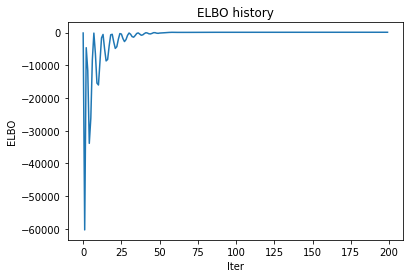

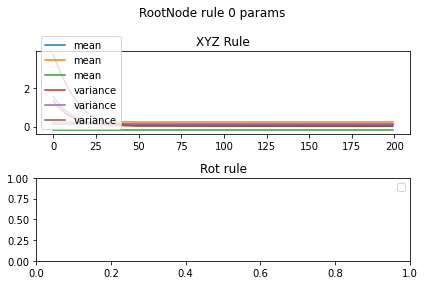

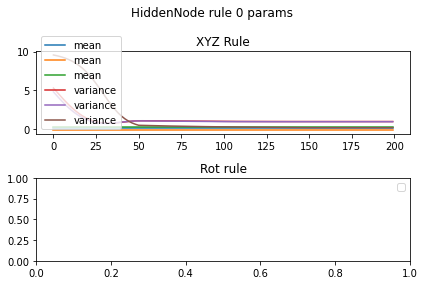

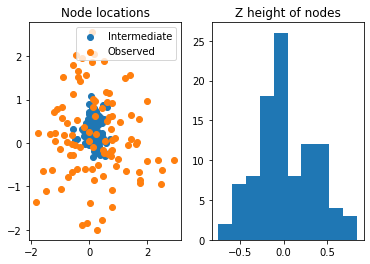

In [6]:
# Plot param history for a node type in the grammar.
def plot_elbo_history(self):
    plt.figure()
    plt.plot(torch.stack(self.elbo_history).detach())
    plt.title("ELBO history")
    plt.xlabel("Iter")
    plt.ylabel("ELBO")

def plot_grammar_parameter_history(self, node_type):
    assert hasattr(self, "grammar_major_iters") and len(self.grammar_major_iters) > 0
    assert node_type in self.grammar.all_types
    
    all_state_dicts = [x for l in self.grammar_major_iters for x in l]
    node_param_history = []
    rule_param_history = None
    for state_dict in all_state_dicts:
        self.grammar.load_state_dict(state_dict)
        possible_params = self.grammar.params_by_node_type[node_type.__name__]
        if possible_params:
            node_param_history.append(possible_params().detach())
        rule_params = self.grammar.rule_params_by_node_type[node_type.__name__]
        if rule_param_history is None:
            rule_param_history = [[{}, {}] for k in range(len(rule_params))]
        
        for k, (xyz_rule_params, rot_rule_params) in enumerate(rule_params):
            for key, value in xyz_rule_params.items():
                hist_dict = rule_param_history[k][0]
                if key not in hist_dict:
                    hist_dict[key] = [value().detach()]
                else:
                    hist_dict[key].append(value().detach())
            for key, value in rot_rule_params.items():
                hist_dict = rule_param_history[k][1]
                if key not in hist_dict:
                    hist_dict[key] = [value().detach()]
                else:
                    hist_dict[key].append(value().detach())

    if len(node_param_history) > 0:
        node_param_history = torch.stack(node_param_history)
    for entry in rule_param_history:
        for k in range(2): # xyz / rot rule
            for key, value in entry[k].items():
                entry[k][key] = torch.stack(value)

    if len(node_param_history) > 0:
        plt.figure()
        plt.plot(node_param_history)
        plt.title("%s params" % node_type.__name__)
        print("Final params: ", node_param_history[-1, :])
    
    # Rules
    plt.figure()
    N_rules = len(rule_param_history)
    for k, entry in enumerate(rule_param_history):
        plt.suptitle("%s rule %d params" % (node_type.__name__, k))
        # XYZ
        plt.subplot(2, N_rules, k+1)
        plt.title("XYZ Rule")
        for key, value in entry[0].items():
            plt.plot(value, label=key)
            print("%d:xyz:%s final: %s" % (k, key, value[-1, :]))
        plt.legend()
        plt.subplot(2, N_rules, k + N_rules + 1)
        plt.title("Rot rule")
        for key, value in entry[1].items():
            plt.plot(value, label=key)
            print("%d:rot:%s final: %s" % (k, key, value[-1, :]))
        plt.legend()
    plt.tight_layout()

def plot_post_fit_tree_samples(self, N_samples=100):
    samples = []
    for k in range(100):
        samples.append(self.grammar.sample_tree(detach=True))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Node locations")
    l = get_all_node_xyzs(samples, HiddenNode)
    plt.scatter(l[:, 0], l[:, 1], label="Intermediate")
    l = get_all_node_xyzs(samples, VisibleNode)
    plt.scatter(l[:, 0], l[:, 1], label="Observed")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.hist(l[:, 2])
    plt.title("Z height of nodes")


plot_elbo_history(svi)
plot_grammar_parameter_history(svi, RootNode)
plot_grammar_parameter_history(svi, HiddenNode)

plot_post_fit_tree_samples(svi)